<a href="https://colab.research.google.com/github/axel-sirota/tf-dev-nlp/blob/main/module4/TF_Developer_NLP_Module4_Demo1_Intent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Categorizing intent


## Setup

Let's first import everything and load the dataset

In [ ]:
#https://github.com/axel-sirota/tf-dev-nlp

In [9]:
# !pip install -q textblob 'gensim==4.3.0' np-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [8]:
import multiprocessing
import tensorflow as tf
import sys
from tensorflow.python.keras import backend as K
# import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, Input
# from keras.utils import np_utils
import np_utils
from keras.preprocessing import sequence
# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
# from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import pad_sequences
from keras.initializers import Constant
from tensorflow.nn import leaky_relu
import re
import random
import os
import gensim
import numpy as np
import pandas as pd
import warnings
import nltk

epochs = 100
embedding_dim = 100
TRACE = False

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config)
  K.set_session(sess)

In [5]:
set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
textblob_tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Now we will download the dataset and explore it

In [6]:
%%writefile get_data.sh
if [ ! -f intents.csv ]; then
  wget -O intents.csv https://www.dropbox.com/s/smy3os4px8ionkx/atis_intents.csv?dl=0
fi

if [ ! -f glove.6B.100d.txt ]; then
  wget -O glove.6B.100d.txt https://www.dropbox.com/s/dl1vswq2sz5f1ws/glove.6B.100d.txt?dl=0
fi

Writing get_data.sh


In [7]:
!bash get_data.sh ~V


--2024-09-08 15:10:16--  https://www.dropbox.com/s/smy3os4px8ionkx/atis_intents.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/q14e7vvqkjitlspbiygmj/atis_intents.csv?rlkey=uusatqo9tw8n6izc1uv7drb1g&dl=0 [following]
--2024-09-08 15:10:16--  https://www.dropbox.com/scl/fi/q14e7vvqkjitlspbiygmj/atis_intents.csv?rlkey=uusatqo9tw8n6izc1uv7drb1g&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc303eebb7b24f0c1b07f85bb8f3.dl.dropboxusercontent.com/cd/0/inline/CaPmrZi0ha_cZE99rm63ACGwYg9f5o7RzmTMijlZZtSYG7vL8IouSq9qaJ0jTWTbzQPaiRbsrc0Kpo-zcdKLzwV9Txyle7AT_6PcmChhc81VD2yTVBxIBAE_qZgNJsv5MsoPA8DBY1pwfZQfVXp6hftV/file# [following]
--2024-09-08 15:10:17--  https://uc303eebb7b24f0c1b07f85bb8f3.dl.dropboxus

Let's inspect how this intents csv looks like

In [ ]:
!head intents.csv

atis_flight, i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
atis_flight, what flights are available from pittsburgh to baltimore on thursday morning
atis_flight_time, what is the arrival time in san francisco for the 755 am flight leaving washington
atis_airfare, cheapest airfare from tacoma to orlando
atis_airfare, round trip fares from pittsburgh to philadelphia under 1000 dollars
atis_flight, i need a flight tomorrow from columbus to minneapolis
atis_aircraft, what kind of aircraft is used on a flight from cleveland to dallas
atis_flight, show me the flights from pittsburgh to los angeles on thursday
atis_flight, all flights from boston to washington
atis_ground_service, what kind of ground transportation is available in denver


In [9]:
def preprocess_text(text, should_join=True):
    text = ' '.join(str(word) for word in textblob_tokenizer(text))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    if should_join:
      return ' '.join(gensim.utils.simple_preprocess(text))
    else:
      return gensim.utils.simple_preprocess(text)

In [11]:
path = './intents.csv'
intents = pd.read_csv(path, header=None, names=["intent", "query"])

Let's inspect the intents

In [12]:
intents.intent.value_counts()

,intent
atis_flight,3666
atis_airfare,423
atis_ground_service,255
atis_airline,157
atis_abbreviation,147
atis_aircraft,81
atis_flight_time,54
atis_quantity,51
atis_flight#atis_airfare,21
atis_airport,20


Let's filter the rows with a rare intent since we will not be able to predict it neverthenless

In [13]:
intents_filtered = intents.groupby('intent').filter(lambda x: len(x) >= 15).reset_index()
print(f" Eliminitaded records: {intents.shape[0]-intents_filtered.shape[0]}")

 Eliminitaded records: 30


In [14]:
X = intents_filtered['query']
y = intents_filtered.intent


If we inspect y, now we need to transform it into a one hot representation!

## Creating the corpus and tokenizing

In [15]:
corpus_with_ix = [(ix, preprocess_text(sentence, should_join = True)) for ix, sentence in X.iteritems() if type(sentence) == str and len(textblob_tokenizer(sentence)) > 3]


In [16]:
corpus_with_ix[0]

(0, 'want to fly from boston at am and arrive in denver at in the morning')

In [17]:
corpus_df = pd.DataFrame(corpus_with_ix, columns=['index', 'text'])

In [18]:
corpus_df.shape

(4871, 2)

In [19]:
y_filtered = y[corpus_df['index']]

In [20]:
def get_corpus(corpus_df):
  corpus=[]
  max_review_length=0

  for ix, sentence in corpus_with_ix:
    proc_sentence=preprocess_text(sentence, should_join=False)

    if len(proc_sentence) > max_review_length:
      max_review_length = len(proc_sentence)

    corpus.append(proc_sentence)

  return corpus, max_review_length


In [21]:
corpus,max_review_length = get_corpus(corpus_df)

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
tokenized_corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

698

In [23]:
final_X = np.zeros((len(tokenized_corpus), max_review_length))
for ix, tokenized_sentence in enumerate(tokenized_corpus):
    tokenized_sentence.extend([0]*(max_review_length-len(tokenized_sentence)))
    final_X[ix] = tokenized_sentence

Since y_filtered (and y) have many text values, we need to map each intent into a number. We will use the `pd.factorize` method for that.

In [24]:
y_factorized, level_intents = pd.factorize(y_filtered)

## Creating the embedding matrix

This is the same part, we will construct an embedding matrix that maps each word in the tokenizer (via the ID it gets in the dataset) to the GloVe 100 dimensional representation of that word. This will be the input to the Embedding layer.

In [25]:
path_to_glove_file = "./glove.6B.100d.txt"
embeddings_index = {}

with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors")

Found 400001 word vectors


In [26]:
lembedding_dim = 100
num_tokens = vocab_size + 1
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words {misses}")

Converted 696 words 1


## Doing the train_test split and defining model

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_X, y_factorized, test_size = 0.3, random_state=42)

In [28]:
X_train_tensor = tf.constant(X_train)
X_test_tensor = tf.constant(X_test)
y_train_tensor = tf.one_hot(tf.constant(y_train), len(level_intents))
y_test_tensor = tf.one_hot(tf.constant(y_test), len(level_intents))

In [34]:
X_train_tensor[0]

<tf.Tensor: shape=(43,), dtype=float64, numpy=
array([14., 16., 36., 23., 82.,  5., 47., 52.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])>

Notice that our y has many values, we need to use `tf.one_hot` to convert it to the corresponding input to the loss function

In [32]:
print(f"""X_train shape: {X_train_tensor.shape}, X_test shape: {X_test_tensor.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}""")

X_train shape: (3409, 43), X_test shape: (1462, 43), y_train shape: (3409,), y_test shape: (1462,)


Now we have the key step, we will set the output neurons to be the amount of intents, with softmax as activation. Therefore this model will predict probabilities that each input inquiry is of certain classes

In [60]:
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0],output_dim=embedding_matrix.shape[1], input_length=max_review_length, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(Dense(100, activation=leaky_relu))
model.add(Dense(50, activation=leaky_relu))
model.add(Lambda(lambda x: K.mean(x, axis=1)))
model.add(Dense(50, activation=leaky_relu))
model.add(Dense(len(level_intents), activation='softmax'))

In [63]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
model.summary() # model summary shows output after fit.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 43, 100)             │          69,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 43, 100)             │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 43, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_3 (Lambda)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 14)                  │             714 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,314 (344.98 KB)

 Trainable params: 18,414 (71.93 KB)

 Non-trainable params: 69,900 (273.05 KB)

Notice the non-trainable parameters

In [62]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_precision', patience=10, min_delta=0.01, mode="max")
history = model.fit(X_train_tensor, y_train_tensor, epochs = 30, validation_split=0.2, callbacks=[callback])

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6972 - loss: 1.6724 - precision: 0.6515 - recall: 0.3344 - val_accuracy: 0.7669 - val_loss: 0.9851 - val_precision: 0.8070 - val_recall: 0.7419
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7335 - loss: 1.0037 - precision: 0.7978 - recall: 0.7231 - val_accuracy: 0.7683 - val_loss: 0.8285 - val_precision: 0.8540 - val_recall: 0.7463
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7480 - loss: 0.8471 - precision: 0.8541 - recall: 0.7117 - val_accuracy: 0.8021 - val_loss: 0.7365 - val_precision: 0.9047 - val_recall: 0.7375
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8044 - loss: 0.7100 - precision: 0.9008 - recall: 0.7257 - val_accuracy: 0.8284 - val_loss: 0.6530 - val_precision: 0.8960 - val_recall: 0.7581
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8532 - loss: 0.5966 - precision: 0.9187 - recall: 0.7834 - val_accuracy: 0.8446 - val_loss: 0.5698 -

## Some plots

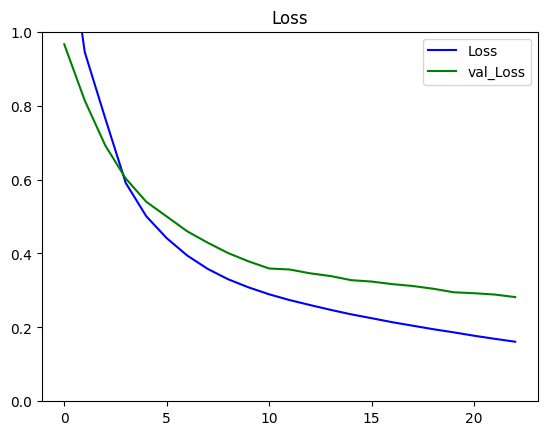

In [41]:
import matplotlib.pyplot as plt
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)


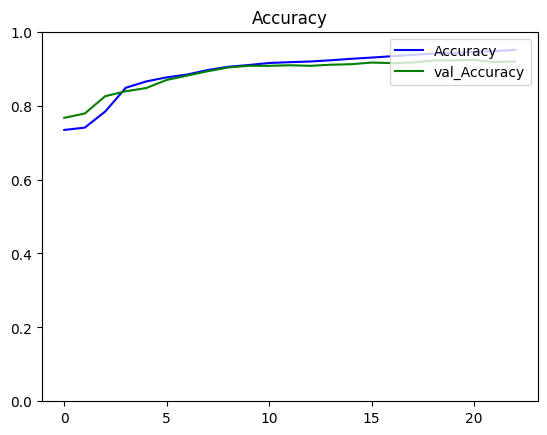

In [42]:
plot_metrics(history.history['accuracy'], history.history['val_accuracy'], "Accuracy", "Accuracy", ylim=1.0)


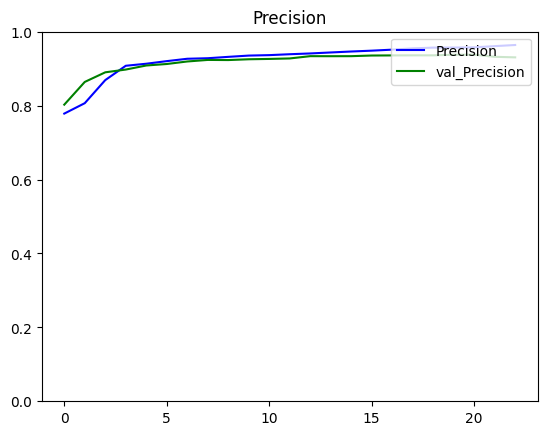

In [43]:
plot_metrics(history.history['precision'], history.history['val_precision'], "Precision", "Precision", ylim=1.0)


# Some manual validation

In [ ]:
level_intents

Index(['atis_flight', 'atis_flight_time', 'atis_airfare', 'atis_aircraft',
       'atis_ground_service', 'atis_airport', 'atis_airline', 'atis_distance',
       'atis_abbreviation', 'atis_ground_fare', 'atis_quantity', 'atis_city',
       'atis_capacity', 'atis_flight#atis_airfare'],
      dtype='object')

In [ ]:
x_val = np.zeros((4, max_review_length))
queries = ['Which hour is the next flight', 'how many flights leave in the morning', 'i want to flight to new york at the morning', 'which flight flies with an airbus A350']
for ix, tokenized_sentence in enumerate(tokenizer.texts_to_sequences([preprocess_text(sentence, should_join=True) for sentence in queries])):
    tokenized_sentence.extend([0]*(max_review_length-len(tokenized_sentence)))
    x_val[ix] = tokenized_sentence
y_val = tf.one_hot(tf.constant([1, 10, 0, 3 ]), 14)

In [45]:
x_val = np.zeros((4, max_review_length))
x_val

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
model.predict(x_val)

1/1 [==============================] - 0s 151ms/step


array([[9.87922609e-01, 4.83939238e-03, 1.23033797e-05, 1.14638948e-04,
        5.38179120e-06, 2.76700710e-03, 2.11087591e-03, 1.34268557e-04,
        5.22008013e-05, 9.86671125e-07, 7.82972143e-04, 1.21533289e-03,
        2.06917539e-05, 2.12740324e-05],
       [5.67750186e-02, 1.89499147e-02, 1.89591054e-04, 1.67286408e-03,
        2.09380858e-07, 2.72134843e-04, 2.19631963e-03, 1.15288385e-04,
        2.85549345e-03, 1.08795293e-05, 8.94409180e-01, 3.63733550e-03,
        1.81336049e-02, 7.82170973e-04],
       [9.99499798e-01, 2.25996191e-04, 9.46959915e-07, 3.53670725e-06,
        3.66155348e-07, 1.44660444e-04, 8.03058501e-05, 1.11767931e-05,
        2.36375186e-07, 2.58016204e-08, 2.62982235e-06, 2.98261621e-05,
        5.60844136e-08, 4.63504222e-07],
       [9.65652168e-01, 3.64327658e-04, 1.82500614e-07, 3.89954686e-04,
        2.27665478e-05, 8.58227629e-03, 1.23124216e-02, 5.08750818e-05,
        6.19870718e-07, 4.35138475e-07, 5.39100030e-04, 1.20226871e-02,
        6.073

In [ ]:
tf.math.argmax(model.predict(x_val), axis=1)

1/1 [==============================] - 0s 17ms/step


<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 0, 10,  0,  0])>

In [ ]:
tf.math.argmax(model.predict(x_val), axis=1) == tf.math.argmax(y_val, axis=1)

1/1 [==============================] - 0s 18ms/step


<tf.Tensor: shape=(4,), dtype=bool, numpy=array([False,  True,  True, False])>

In [ ]:
tf.math.argmax(y_val, axis=1)

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 1, 10,  0,  3])>

In [ ]:
model.evaluate(X_test_tensor, y_test_tensor)

46/46 [==============================] - 0s 5ms/step - loss: 0.1501 - accuracy: 0.9596 - precision: 0.9666 - recall: 0.9494


[0.15012985467910767,
 0.9596443176269531,
 0.9665738344192505,
 0.9493843913078308]

Therefore, the model is amazing, reaching 95% accuracy and F1 score

In [67]:
for _ in model.layers:
  try:
    print(_.output.shape)
  except Exception as e:
    pass

(None, 43, 100)
(None, 43, 100)
(None, 43, 50)
(None, 50)
(None, 50)
(None, 14)
